# Dimensionality-reduction-demo-PCA

In this notebook, I will discuss how to perform principal component analysis (PCA). I will use [data](https://doi.gin.g-node.org/10.12751/g-node.b0mnn2/) from a [recently published paper in Neuron](https://www.cell.com/neuron/fulltext/S0896-6273(20)30995-8?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0896627320309958%3Fshowall%3Dtrue). It is data simultaneously recorded from V1 and V4 using 16-contact laminar electrodes during an attention-demanding task. For specifics about the task and recordings I'll refer you to the paper, or [this post](https://jochemvankempen.github.io/posts/2021/01/04/dimensionality-reduction-demo.html), but the important things to know to follow the analysis below are:
- Three stimuli were presented
    - the stimuli were exactly the same on each trial
    - one of the stimuli was presented inside the RF of the recorded neurons
- The cue, indicating which of the 3 stimuli to attend to, was presented after the stimuli. This means that the cognitive "attention" signal only originates a few 100 ms after the onset of the cue.

See [figure 1](https://www.cell.com/neuron/fulltext/S0896-6273(20)30995-8?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0896627320309958%3Fshowall%3Dtrue#fig1) for more details on the paradigm.

Below, I'll load the packages and the data, give a brief description of the data, and then go over the PCA procedure step-by-step.

In [1]:
# import packages
import sys
from matplotlib import pyplot as plt
from matplotlib import rcParams 
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import numpy.matlib
import os
from sklearn.decomposition import PCA 

# custom packages/modules
from pyplotj import animj
from neuroimport import matlabimport

In [2]:
# set default plot params
rcParams['font.size'] = 16
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

# Loading data

In [3]:
# define path and URL
data_path = '/Users/jochemvankempen/NCL/gratc/data/processed/Wyman/2016-01-22'
# data_url = 'https://gin.g-node.org/jochemvankempen/Thiele-attention-gratc-V1-V4-laminar/src/master/data/processed/W/2016-01-22/'

# load data
loadfilename = os.path.join(data_path, 'MUAe.mat')
data = matlabimport.load_data(loadfilename,'StimAlign','CueAlign','area','unitList')
loadfilename = os.path.join(data_path, 'trialdata.mat')
trialdata = matlabimport.load_trialdata(loadfilename)

Now lets see what the files contain

In [4]:
print(f'data is a {type(data)}')
print('It contains the keys :', *data.keys(), sep='\n', end='\n')    
    
print('\nIn data, the element StimAlign contains: ', *data['StimAlign'].keys(), sep='\n', end='\n')
    
print('\nTimeStamps is a', np.shape(data['StimAlign']['TimeStamps']), 'vector')
print('Samples is a', np.shape(data['StimAlign']['Samples']), 'matrix with ', 
      np.shape(data['StimAlign']['Samples'])[0], ' channels,', 
      np.shape(data['StimAlign']['Samples'])[1], ' trials and', 
      np.shape(data['StimAlign']['Samples'])[2], ' time points \n')


print(f'trialdata is a {type(trialdata)} , containing the keys :', *trialdata.keys(), sep='\n')


data is a <class 'dict'>
It contains the keys :
__header__
__version__
__globals__
StimAlign
CueAlign
unitList
area

In data, the element StimAlign contains: 
TimeStamps
Samples

TimeStamps is a (1, 3052) vector
Samples is a (32, 746, 3052) matrix with  32  channels, 746  trials and 3052  time points 

trialdata is a <class 'pandas.core.frame.DataFrame'> , containing the keys :
trial_ID
attend
cond
RT_evnt
RT_EPP
target_dim
rf_dim
position_RF
position_out1
position_out2
fixbreak
CTX_events
NLX_events


The dictionary `data` contains `StimAlign` and `CueAlign`, with the neural data aligned to stimulus and cue onset, respectively. The dataframe `trialdata` contains the metadata, such as on which trial attention was directed to which of the three stimuli (`trialdata["attend"]`). 



# Define parameters

In [5]:
# define some parameters

# define areas
areas = np.unique(data['area'])
num_areas = np.size(areas)

# define conditions
conditions = ['Attend RF', 'Attend away1', 'Attend away2']
num_cond = np.size(np.unique(trialdata['attend']))

# define time windows
time_window = {
    'Baseline': [-0.25, 0], 
    'Stimulus': [0.03, 0.2],
    'Sustained':[0.2, 1],
    'Attend': [0.6, 1],
    'Cue': [-0.2, 1]
    }

print(f'Brain areas recorded from:{areas}')


Brain areas recorded from:['V1' 'V4']


# Data inspection
## Stimulus-aligned activity
Next we have a look at the data, starting with the trial-averaged activity aligned to stimulus onset. 

As you can see, there is a reliable stimulus-induced response on most of the channels. 

Note: we subtract baseline activity to get a good idea of any changes to the activity induced by stimulus presentation.



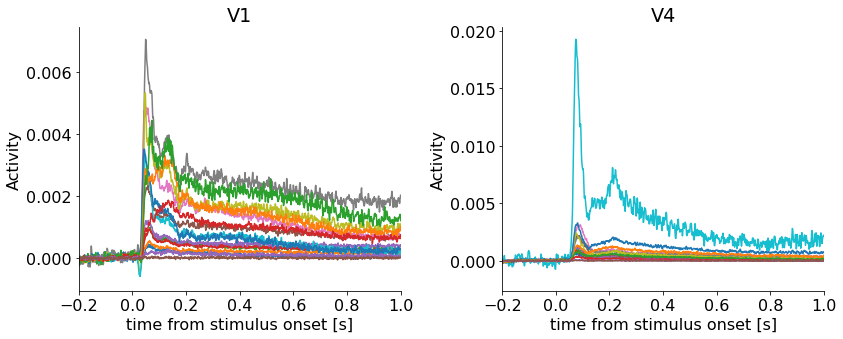

In [6]:
# Plot average stim-aligned activity
# ----------------------------------

event = 'StimAlign'

# extract the indices for the baseline time window
cond1 = data[event]['TimeStamps'][0] > time_window['Baseline'][0] # time points larger than time_window['Baseline'][0]
cond2 = data[event]['TimeStamps'][0] <= time_window['Baseline'][1] # time points smaller than time_window['Baseline'][1]
idx_time = np.where(cond1 & cond2)[0]

# compute trial-averaged baseline activity for each channel
baseline_activity = data[event]['Samples'][:,:,idx_time].mean(axis=(1,2))

# loop over areas to plot baseline-subtracted activity
plt.figure(figsize=(12,5)) 
for iarea, area in enumerate(areas):
    
    idx_unit = np.where(data['area']==area)[0]# select units to plot per area
  
    ax = plt.subplot(1,num_areas,iarea+1,facecolor="none")
    
    for iunit in idx_unit:
                          
        ax.plot( data[event]['TimeStamps'][0], (data[event]['Samples'][iunit,:,:].mean(axis=0) - baseline_activity[iunit]) )

    ax.set(xlabel='time from stimulus onset [s]', ylabel='Activity')
    ax.set_xlim(left=-0.2, right=1.0)
    ax.set(title=area)
    # ax.set()

plt.show()


## Cue-aligned activity

The information which of the three stimuli attention should be directed towards is provided at the time of cue onset. The dictionary element `data['CueAlign']` contains the data aligned to the onset of the cue.

This plot shows the trial and channel averaged activity for each of the three attention conditions. After onset of the cue, when attention is directed towards the RF, activity increases relative to the other two conditions. 


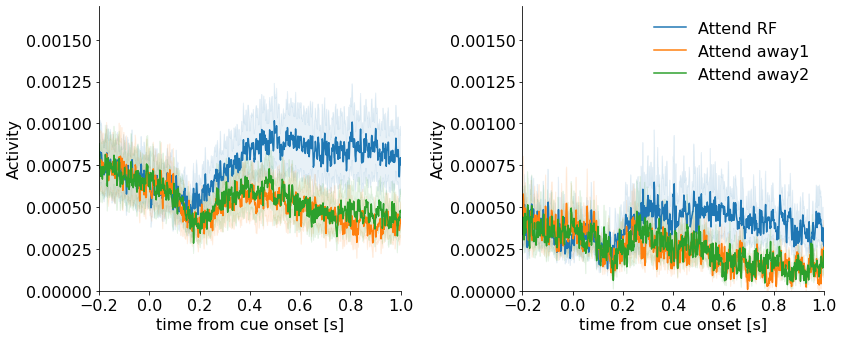

In [7]:
# loop over areas to plot baseline-subtracted activity aligned to cue
plt.figure(figsize=(12,5)) 
for iarea, area in enumerate(areas):
    
    idx_unit = np.where(data['area']==area)[0]# select units to plot per area
  
    ax = plt.subplot(1,num_areas,iarea+1,facecolor="none")
    
    for icond, cond in enumerate(conditions):

        # find trials for attention condition
        idx_trial = trialdata['attend']==(icond+1)
        
        # extract data for this area/condition, subtract baseline activity
        plotdata = data['CueAlign']['Samples'][idx_unit,:,:] # select units
        plotdata = plotdata[:,idx_trial,:].mean(axis=1) # select and average over trials
        plotdata = plotdata - np.matlib.repmat(baseline_activity[idx_unit, np.newaxis], 1, np.shape(plotdata)[1]) # subtract baseline activity
           
        # get y, y_err    
        y = plotdata.mean(axis=0)
        y_err = plotdata.std(axis=0)/np.sqrt(np.size(idx_unit)) # SE

        # plot                      
        p = ax.plot( data['CueAlign']['TimeStamps'][0],  y)
        ax.fill_between(data['CueAlign']['TimeStamps'][0], y-y_err, y+y_err, color=p[0].get_color(), alpha=0.1)
        
    ax.set(xlabel='time from cue onset [s]', ylabel='Activity')
    ax.set_xlim(left=-0.2, right=1.0)
    ax.set_ylim(bottom=0, top=0.0017)

    # ax.set(title=area)
    if iarea==(num_areas-1):
        ax.legend(conditions,frameon=False)
   
plt.show()
    

# Dimensionality reduction
Now that we have a basic understanding of the activity present in this data, we will go over eigendecomposition and principal component analysis (PCA).

The goal is to find a low-dimensional representation that captures much of the variance (information) of the original high-dimensional data. In this case, we have a recording of 16 channels per area, so our data is 16-dimensional. 

To some degree, neural activity covaries between the channels within one area (and possibly between areas), i.e. the trial-to-trial variability in neural responses is shared across channels. This covariance reveals structure in the data; we assume that:
- directions of large variation represent signal (interesting features in the data)
- directions of small variation represent noise 

The goal of PCA is to find these directions of maximal covariance. Once identified, we can project the data onto these directions and represent the data in a lower dimensional space. The directions of maximal variance in the data are the directions indicated by [the eigenvectors](https://www.youtube.com/watch?v=PFDu9oVAE-g) of the covariance matrix.

How do we perform PCA?
1. Subtract the mean
2. Calculate the eigenvectors of the covariance matrix, sorted by the corresponding eigenvalue
3. Project the data onto the new basis


## Covariance matrix
Lets first have a look at the covariance and correlation coefficients for each area. We'll start by doing this for the average activity during a specified timewindow (`time_window['Cue']`). 

Having averaged over time, our data are matrices of size (16 channels [per area] $\times$ 746 trials). We will need to transpose this matrix to follow convention and allow the necessary matrix multiplication. Thus, we will then have matrix $X$ of size 746 $\times$ 16.

The covariance matrix is obtained by $X^{T}X$ (`np.cov` also normalises by $n-1$ corresponding to the degrees of freedom, where $n$ is the number of samples, i.e. trials) and results in a matrix of size 16 $\times$ 16, with an entry on both axes for each channel. Values in this matrix indicate whether activity between channel pairs co-varies across trials (with unit: activity$^{2}$). The covariance matrix $X^{T}X$ encodes all the linear interactions among the variables/columns of X.

I also plotted the correlation coefficients, which is the normalised version of the covariance matrix (normalised by $\sqrt{var(x_{1})var(x_{2})}$ ), scaling the covariance values between -1 and 1. This sometimes gives a little more insight into which channels/features covary. For instance in V4, the activity in one of the channels is much larger than the others, which makes it difficult to see which other channels covary. 

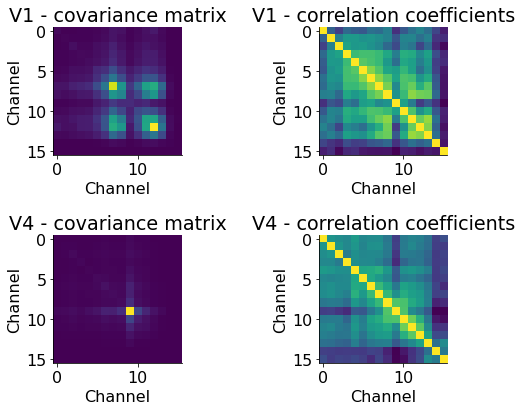

In [8]:
event = 'CueAlign'

# get activity per channel and trial
cond1 = data[event]['TimeStamps'][0] > time_window['Attend'][0]
cond2 = data[event]['TimeStamps'][0] <= time_window['Attend'][1]
idx_time = cond1 & cond2
attention_activity = data[event]['Samples'][:,:,idx_time].mean(axis=2) #

# get corresponding baseline activity
cond1 = data['StimAlign']['TimeStamps'][0] > time_window['Baseline'][0]
cond2 = data['StimAlign']['TimeStamps'][0] <= time_window['Baseline'][1]
idx_time = cond1 & cond2
baseline_activity = data['StimAlign']['Samples'][:,:,idx_time].mean(axis=(2))

attention_activity = attention_activity - baseline_activity

# mean centre
attention_activity = attention_activity - np.mean(attention_activity, axis=1)[:,np.newaxis]

plotdata = {}
plt.figure(figsize=(8,6)) 
for iarea, area in enumerate(areas):
    
    idx_unit = data['area']==area # select units to plot per area

    plotdata[area] = attention_activity[idx_unit,:].T # transpose to (trials x channels) 
    
    # calculate covariance and correlation coefficient matrix
    #     cov_matrix = plotdata[area].T @ plotdata[area]
    cov_matrix = np.cov(plotdata[area], bias=True, rowvar=False)
    corr_matrix = np.corrcoef(plotdata[area], rowvar=False)
    
    # plot covariance
    ax = plt.subplot(num_areas, 2, 1+(num_areas*iarea))
    ax.imshow(cov_matrix) 
    ax.set_xlabel('Channel')
    ax.set_ylabel('Channel')
    ax.set_title(area + ' - covariance matrix')

    # plot correlations
    ax = plt.subplot(num_areas, 2, 2+(num_areas*iarea))
    ax.imshow(corr_matrix) 
    ax.set_xlabel('Channel')
    ax.set_ylabel('Channel')
    ax.set_title(area + ' - correlation coefficients')

plt.show()


## Eigendecomposition
Now we turn to eigendecomposition of this covariance matrix and projecting the data on the directions that explain most variance.


In [9]:
# define some functions

def change_basis(X, evecs):
    """
    Projects data onto a new basis.
    
    Parameters
    ----------
    X : numpy array of floats
        Data matrix each column corresponding to a different variable
    evecs : numpy array of floats
        new orthonormal basis; columns correspond to basis vectors
    
    Returns
    -------
    Y : numpy array of floats 
        Data matrix expressed in new basis
    """        
    
    # check the dimensions match
    assert np.shape(X)[1]==np.shape(evecs)[0], 'Inner dimensions X and evecs do not match'
    
    Y = X@evecs
    return Y



### An example using two channels
We will first run the entire procedure across a subset of the data, the activity from 2 channels. Here, our data matrix `data_mat` is thus 746 $\times$ 2. 

In [10]:
# param
idx_unit = [6,7] # select units to plot 

# extract data
data_mat = plotdata['V1'][:,idx_unit]
data_mat = data_mat*1e3 # change unit for plotting ease

# compute covariance matrix
cov_matrix = np.cov(data_mat, bias=True, rowvar=False)

# eigendecomposition
evals, evectors = np.linalg.eigh(cov_matrix)

# sort eigenvalues/vectors by eigenvalue
index = np.flip(np.argsort(evals))
evals = evals[index]
evectors = evectors[:, index]

# project data onto orthonormal basis
data_proj = change_basis(data_mat, evectors)


# Note that the same can be achieved using singular value decomposition (svd)
# U,S,V = np.linalg.svd(cov_matrix)
# data_proj = change_basis(data_mat, U)


#### Inspect matrix sizes and orthonormal basis
We can inspect the matrix sizes and some key properties of the eigendecomposition/data in order to get a better understanding of what is happening here. 

Some key properties of PCA:
1. Eigenvectors are orthogonal
2. As a result, the components (columns) of the projected data are uncorrelated
3. The variance of each component of the projected data is equal to its corresponding eigenvalue


In [11]:
# Matrix sizes
print(f'data_mat shape is {np.shape(data_mat)}')
print(f'cov_matrix shape, obtained by (data_mat.T @ data_mat), is {np.shape(cov_matrix)}')
print(f'eigenvector matrix shape is {np.shape(evectors)}')
print(f'data_proj shape, obtained by (data_mat @ evectors), is {np.shape(data_proj)}')

data_mat shape is (746, 2)
cov_matrix shape, obtained by (data_mat.T @ data_mat), is (2, 2)
eigenvector matrix shape is (2, 2)
data_proj shape, obtained by (data_mat @ evectors), is (746, 2)


In [12]:
# Key property 1.
# Verify the eigenvectors are orthogonal.

# if eigenvectors are orthogonal, the dot product between eigenvectors is zero, but the dot product with itself is 1. 
# The matrix multiplication between eigenvectors should thus result in the identity matrix.
print(np.round(evectors.T@evectors))

# Note that the eigendecomposition of a symmetric matrix always has orthogonal eigenvectors

[[ 1. -0.]
 [-0.  1.]]


In [13]:
# Key property 2.
# Verify the components of the projected data are uncorrelated (within numerical precision)

corr_matrix = np.corrcoef(data_proj, rowvar=False)
print(corr_matrix)


[[1.00000000e+00 2.00982739e-16]
 [2.00982739e-16 1.00000000e+00]]


In [14]:
# Key property 3.
# Verify that the variance of the components is equal to their corresponding eigenvalue

print(np.var(data_proj, axis=0))
print(evals)

[1.41607049 0.07771349]
[1.41607049 0.07771349]


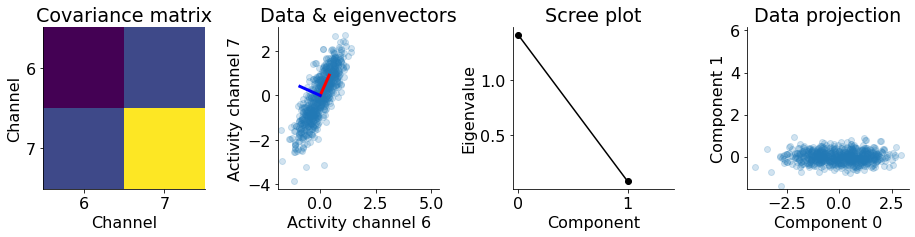

In [15]:
# plotting
# --------
num_plots = 4

plt.figure(figsize=(13,6), facecolor="none") 

# plot covariance matrix
ax = plt.subplot(1, num_plots, 1, facecolor="none")
ax.imshow(cov_matrix) 
ax.set_xlabel('Channel')
ax.set_ylabel('Channel')
ax.set_title('Covariance matrix')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(idx_unit)
ax.set_yticklabels(idx_unit)

# plot data covariance with eigenvectors
ax = plt.subplot(1, num_plots, 2, facecolor="none")
ax.scatter(data_mat[:,0], data_mat[:,1], alpha=0.2)
ax.plot([0, evectors[0, 0]], [0, evectors[1, 0]], color='r', linewidth=3, label='Basis vector 1')
ax.plot([0, evectors[0, 1]], [0, evectors[1, 1]], color='b', linewidth=3, label='Basis vector 2')
ax.set_xlabel('Activity channel ' + str(idx_unit[0]))
ax.set_ylabel('Activity channel ' + str(idx_unit[1]))
ax.set_title('Data & eigenvectors')
ax.axis('square')
# ax.legend()

# plot eigenvalues
ax = plt.subplot(1, num_plots, 3, facecolor="none")
ax.plot(np.arange(0,len(evals)), evals, 'o-k')
ax.set_xlabel('Component')
ax.set_ylabel('Eigenvalue')
ax.set_title('Scree plot')
ax.set_xticks(np.arange(0,len(evals)))
ax.axis('square')

# plot data projected onto orthonormal basis
ax = plt.subplot(1, num_plots, 4, facecolor="none")
ax.scatter(data_proj[:,0], data_proj[:,1], alpha=0.2)
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_title('Data projection')
ax.axis('square')

plt.show()

From left to right we see:
- (panel 1) the covariance matrix for this 2 $\times$ 2 case.
- (panel 2) the activity on each of these two channels (each marker is a trial) and the eigenvectors plotted on top. It is clear from this plot that the activity on these two channels covaries strongly, when there is high activity on one channel, there is likely high activity on the other channel. 
- (panel 3) the "Scree plot" with the eigenvalues. The value of the eigenvalue is directly related to the magnitude of the variability in the direction of its corresponding eigenvector. 
- (panel 4) the data projected on the eigenvectors (imagine that the eigenvectors in panel 2 form the new axes for the data). Rather than channels, we now speak of components in the data. 


# Achieve the same result using PCA
We can replicate this analysis by using the implemented principal component analysis (PCA) function of the `sklearn.decomposition` package in only a few lines of code. 

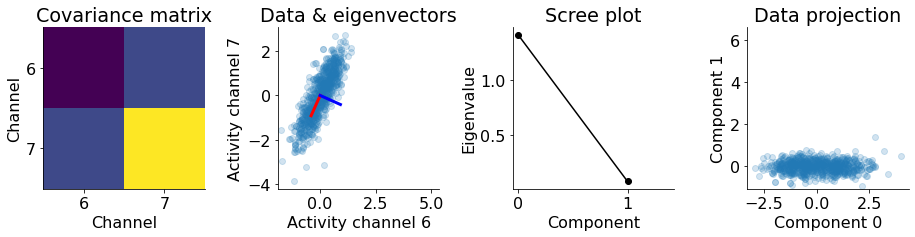

In [16]:
pca = PCA(n_components=2).fit(data_mat)
evectors = pca.components_.T # transpose evectors
evals = pca.explained_variance_

cov_matrix = pca.get_covariance()

data_proj = pca.transform(data_mat)

# plotting, repeat of code in previous cell
# -----------------------------------------
plt.figure(figsize=(13,6), facecolor="none") 

# plot covariance matrix
ax = plt.subplot(1, num_plots, 1)
plt.imshow(cov_matrix) 
ax.set_xlabel('Channel')
ax.set_ylabel('Channel')
ax.set_title('Covariance matrix')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(idx_unit)
ax.set_yticklabels(idx_unit)

# plot data covariance with eigenvectors
ax = plt.subplot(1, num_plots, 2, facecolor="none")
ax.scatter(data_mat[:,0], data_mat[:,1], alpha=0.2)
ax.plot([0, evectors[0, 0]], [0, evectors[1, 0]], color='r', linewidth=3, label='Basis vector 1')
ax.plot([0, evectors[0, 1]], [0, evectors[1, 1]], color='b', linewidth=3, label='Basis vector 2')
ax.set_xlabel('Activity channel ' + str(idx_unit[0]))
ax.set_ylabel('Activity channel ' + str(idx_unit[1]))
ax.set_title('Data & eigenvectors')
ax.axis('square')
# plt.legend()

# plot eigenvalues
ax = plt.subplot(1, num_plots, 3, facecolor="none")
ax.plot(np.arange(0,len(evals)), evals, 'o-k')
ax.set_xlabel('Component')
ax.set_ylabel('Eigenvalue')
ax.set_title('Scree plot')
ax.set_xticks(np.arange(0,len(evals)))
ax.axis('square')
ax.set_xticklabels(np.arange(0, len(evals)))

# plot data projected onto orthonormal basis
ax = plt.subplot(1, num_plots, 4, facecolor="none")
ax.scatter(data_proj[:,0], data_proj[:,1], alpha=0.2)
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_title('Data projection')
ax.axis('square')

plt.show()


# Expand to higher dimensions
Now we use all available channels for one single area. In this case we have 16 channels, so we have a 16-dimensional space that we project to a few principal components that capture most of the variance in the data.
Then, after the projection, we can have a look at whether any of these dimensions explain variance related to any of the task parameters, for instance the attention condition. 

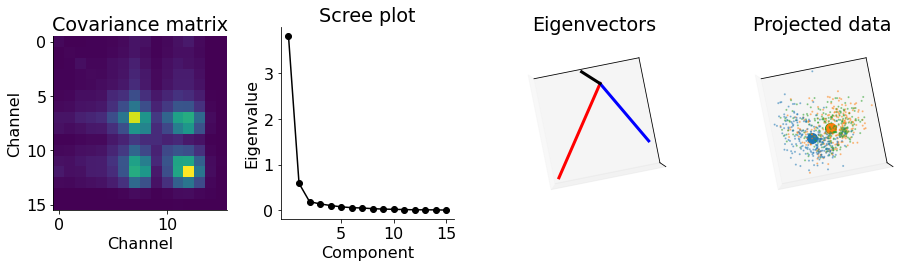

In [17]:
# extract data
data_mat = plotdata['V1']
data_mat = data_mat*1e3 # change unit for plotting ease

# apply PCA
pca = PCA(n_components=16).fit(data_mat)

# get components/eigenvectors and eigenvalues
evectors = pca.components_.T # transpose evectors
evals = pca.explained_variance_

cov_matrix = pca.get_covariance()

data_proj = pca.transform(data_mat)

# data_proj = evectors@data_mat.T
# data_proj = data_proj.T

# plotting
# --------
plt.figure(figsize=(13,4), facecolor="none") 

# plot covariance matrix
ax = plt.subplot(1, num_plots, 1, facecolor="none")
ax.imshow(cov_matrix) 
ax.set_xlabel('Channel')
ax.set_ylabel('Channel')
ax.set_title('Covariance matrix')

# plot eigenvalues
ax = plt.subplot(1, num_plots, 2, facecolor="none")
ax.plot(np.arange(0,len(evals)), evals, 'o-k')
ax.set_xlabel('Component')
ax.set_ylabel('Eigenvalue')
ax.set_title('Scree plot')
ax.set_xticks(np.arange(5, len(evals)+1, 5))
# ax.axis('square')

# plot eigenvectors
ax = plt.subplot(1, num_plots, 3, projection='3d', facecolor="none")
# ax.view_init(elev=10., azim=260)
ax.view_init(elev=90., azim=260)

ax.plot([0, evectors[0,0]], [0, evectors[1,0]], [0,evectors[2,0]], color='r', linewidth=3, label='Basis vector 1')
ax.plot([0, evectors[0,1]], [0, evectors[1,1]], [0,evectors[2,1]], color='b', linewidth=3, label='Basis vector 2')
ax.plot([0, evectors[0,2]], [0, evectors[1,2]], [0,evectors[2,2]], color='k', linewidth=3, label='Basis vector 3')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.zaxis.set_major_locator(plt.NullLocator())
# ax.set_xlabel('Component 0')
# ax.set_ylabel('Component 1')
# ax.set_zlabel('Component 2')
ax.set_title('Eigenvectors')

ax = plt.subplot(1, num_plots, 4, projection='3d', facecolor="none")
# ax.view_init(elev=10., azim=260)
ax.view_init(elev=90., azim=260)
  
for icond, cond in enumerate(conditions):

    # find trials for attention condition
    idx_trial = trialdata['attend']==(icond+1)

    # extract data for this condition
    x = data_proj[idx_trial,0] # select trials, first component
    y = data_proj[idx_trial,1] # select trials, second component
    z = data_proj[idx_trial,2] # select trials, third component

    # plot                      
    p = ax.scatter(x, y, z, alpha=0.4, marker='.', s=5)
    ax.scatter(x.mean(), y.mean(), z.mean(), marker='o', s=100, color=p.get_facecolor()[0][0:3])

ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.zaxis.set_major_locator(plt.NullLocator())
ax.set_title('Projected data')

plt.show()


From left to right we see:
- (panel 1) the covariance matrix.
- (panel 2) the "Scree plot" with the eigenvalues. 
- (panel 3) the first three components.
- (panel 4) the data projected and their means onto the eigenvectors for the first three components (three axes) for the three attention conditions (blue is attend RF).

From this we can conclude that there is one component that explains (by far) the most variance in the data. 
Next, we separate the data according to the attention conditions. Although it is not immediately obvious that information relevant to attention is encoded along these directions, as the center of mass of the three clusters seems to be in a slightly different location, there might be something more to explore there.

# PCA over time

Alright, now for the exciting bit! 
We do not have to pick an arbitrary time window, average the activity in this window and then apply PCA on this activity. We can apply PCA to all the data (over channels, trials and time) at once. 


In [18]:
# Now apply PCA over time
# -----------------------

# extract data over time
event = 'CueAlign'
idx_unit = np.where(data['area']=='V1')[0]# select units to plot per area

# get activity per channel and trial
cond1 = data[event]['TimeStamps'][0] > time_window['Cue'][0]
cond2 = data[event]['TimeStamps'][0] <= time_window['Cue'][1]
idx_time = cond1 & cond2

attention_activity = data[event]['Samples'][:,:,idx_time] #
attention_timeStamps = data[event]['TimeStamps'][0][idx_time]

# repmat baseline_activity
baseline_activity = np.repeat(baseline_activity[:, :, np.newaxis], np.shape(attention_activity)[2], axis=2) # indexing with np.newaxis inserts a new 3rd dimension, which we then repeat the array along

# subtract baseline
attention_activity = attention_activity - baseline_activity

# unit sub-selection
attention_activity = attention_activity[idx_unit,:,:]
attention_activity = attention_activity*1e3 # change unit for plotting ease

# reshape: concatenate across trials
pca_activity = np.reshape(attention_activity, (np.shape(idx_unit)[0],-1))


Lets have a look at the sizes of these matrices. 

In [19]:
print(np.shape(attention_activity))
print(np.shape(pca_activity))

(16, 746, 1221)
(16, 910866)


In [20]:
# mean center
pca_activity = pca_activity - np.mean(pca_activity, axis=1)[:,np.newaxis]
pca_activity = pca_activity.T

# apply PCA
n_components=16
pca = PCA(n_components=n_components).fit(pca_activity)
evectors = pca.components_.T
evals = pca.explained_variance_

# project onto eigenvectors
# data_proj = change_basis(pca_activity, evectors)
data_proj = pca.transform(pca_activity)

# reshape (back) to (component x trial x time)
data_proj = np.reshape(data_proj.T, (n_components, -1, np.shape(attention_activity)[2]))

# get explained variance
evals_percentage = pca.explained_variance_

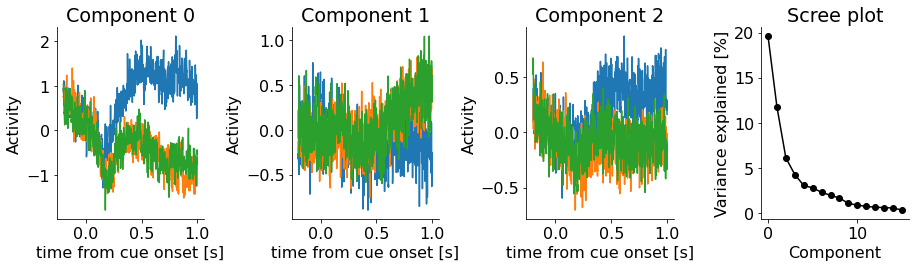

In [21]:
num_plots = 3

# plot
plt.figure(figsize=(13,4), facecolor="none") 

for ipc in range(num_plots):
    ax = plt.subplot(1, num_plots+1, ipc+1, facecolor="none")

    ax.plot(attention_timeStamps, data_proj[ipc, trialdata['attend']==1, :].mean(axis=0))
    ax.plot(attention_timeStamps, data_proj[ipc, trialdata['attend']==2, :].mean(axis=0))
    ax.plot(attention_timeStamps, data_proj[ipc, trialdata['attend']==3, :].mean(axis=0))
    ax.set_title('Component ' + str(ipc))
    ax.set(xlabel='time from cue onset [s]', ylabel='Activity')

ax = plt.subplot(1, num_plots+1, num_plots+1, facecolor="none")
ax.plot(np.arange(0, len(evals_percentage) ), evals_percentage, 'o-k')
ax.set_xlabel('Component')
ax.set_ylabel('Variance explained [%]')
ax.set_title('Scree plot')

plt.show()


When we then sort the data according to the attention conditions, we see that the first component distinguishes between these conditions! 
Thus the component that explains the most variance is the direction in PCA space that is relevant for cognitive (internal) functions such as attention. 

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


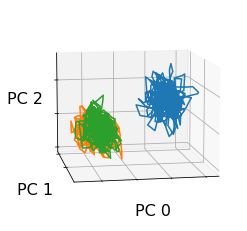

In [22]:
# Plot PCs over time in 3D
# ------------------------

# select a shorter timewindow
cond1 = attention_timeStamps > time_window['Attend'][0]
cond2 = attention_timeStamps <= time_window['Attend'][1]
idx_time = cond1 & cond2
plotdata = data_proj[:,:,idx_time]

fig = plt.figure(facecolor="none")
ax = fig.gca(projection='3d', facecolor="none")
ax.view_init(elev=10., azim=260)
ax.plot3D(
    plotdata[0, trialdata['attend']==1, :].mean(axis=0),
    plotdata[1, trialdata['attend']==1, :].mean(axis=0),
    plotdata[2, trialdata['attend']==1, :].mean(axis=0))

ax.plot3D(
    plotdata[0, trialdata['attend']==2, :].mean(axis=0),
    plotdata[1, trialdata['attend']==2, :].mean(axis=0),
    plotdata[2, trialdata['attend']==2, :].mean(axis=0))

ax.plot3D(
    plotdata[0, trialdata['attend']==3, :].mean(axis=0),
    plotdata[1, trialdata['attend']==3, :].mean(axis=0),
    plotdata[2, trialdata['attend']==3, :].mean(axis=0))

ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
plt.show()

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()


A nice way to visualise these results is to plot the progression of activity in 3D over time. For this I use the [custom `pyplotj.animj` module](https://gitlab.com/JvK/dimensionality-reduction-demo/-/tree/master/pyplotj).

Here we clearly see that a few hundred milliseconds after onset of the cue, the activity in the attend RF condition occupies a different location in PCA space. 

In [23]:
# Create animation of PCs over time in 3D.
# ----------------------------------------
numdims = 3
numsamples = 10

# Attaching 3D axis to the figure
fig = plt.figure(figsize=(12,8)) 
ax = plt.axes(projection='3d')

# set viewpoint of graph
ax.view_init(elev=10., azim=260)

# define data to plot
attend_RF = data_proj[:numdims, trialdata['attend']==1, :].mean(axis=1)
attend_away1 = data_proj[:numdims, trialdata['attend']==2, :].mean(axis=1)
attend_away2 = data_proj[:numdims, trialdata['attend']==3, :].mean(axis=1)

plotdata = np.array([attend_RF, attend_away1, attend_away2])

# Define line and text object
lines = animj.def_lines(ax, plotdata)
ax.legend(lines, ('Attend RF','Attend Away1','Attend Away2'), loc='lower right', frameon=False)

counter = ax.text(20.0, 0.5, 1.0, [],
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='k', fontsize=15)
lines.append(counter)

textCounter = 'Time from cue: %1.3f [s]'

# set axes
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])

numtimes = np.shape(data_proj)[2]
line_anim = animation.FuncAnimation(fig, animj.update_lines_counter, numtimes, 
                                    fargs=(plotdata, lines, textCounter, attention_timeStamps, numsamples), 
                                    interval=30, blit=True, repeat=True)
plt.close()

<ipython-input-23-046e3df5cb94>:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  line_anim = animation.FuncAnimation(fig, animj.update_lines_counter, numtimes,


In [24]:
# note that this takes a while!
rcParams['animation.html'] = 'html5'
line_anim

## Conclusion
Dimensionality reduction and PCA are great ways to explore, summarise and visualise high-dimensional data. I hope this  has been helpful. Have fun applying it to your own data!